In [84]:
from pathlib import Path
import sys
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

sys.path.append("../")
from src.data_processing.feature_selection import select_uncorrelated_features
from src.plots.maps import russia_plots
from src.static.cluster_tools import plot_silhouette_range
from src.utils.logger import setup_logger

logger = setup_logger("hydro_atlas_converter", logger_name="../logs/hydro_atlas_converter.log")

gpd.options.io_engine = "pyogrio"

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


In [196]:
proper_dis = list(
    {
        i.stem
        for i in Path("/home/dmbrmv/Development/camels_ru/data/HydroFiles/Discharge").rglob(
            "decent/*.csv"
        )
    }
)
proper_lvl = list(
    {
        i.stem
        for i in Path("/home/dmbrmv/Development/camels_ru/data/HydroFiles/Levels").rglob("*decent/*.csv")
        if "shifted" not in str(i)
    }
)


ws = gpd.read_file("../data/Geometry/WatershedGeomCAMELS.gpkg")
ws.set_index("gage_id", inplace=True)
ws = ws.loc[[ind for ind in ws.index if (ind in proper_dis)], :]
gauge = gpd.read_file("../data/Geometry/GaugeGeomCAMELS.gpkg")
gauge.set_index("gage_id", inplace=True)
gauge = gauge.loc[[ind for ind in gauge.index if (ind in proper_dis)], :]

basemap_data = gpd.read_file("../data/Geometry/basemap.gpkg")

### Size distribution of catchment areas

In [197]:
def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4, lim_5 = 100, 2000, 10000, 50000, 200000

    if area < lim_1:
        return "a) < 100 $km^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "b) 100 $km^2$ - 2 000 $km^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "c) 2 000 $km^2$ - 10 000 $km^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "d) 10 000 $km^2$ - 50 000 $km^2$"
    elif (area > lim_4) & (area <= lim_5):
        return "e) 50 000 $km^2$ - 200 000 $km^2$"
    else:
        return "f) > 200 000 $km^2$"


ws["size"] = ws.loc[:, "area"].apply(lambda x: lim_definer(x))
ws["size"] = pd.Categorical(
    ws["size"],
    [
        "a) < 100 $km^2$",
        "b) 100 $km^2$ - 2 000 $km^2$",
        "c) 2 000 $km^2$ - 10 000 $km^2$",
        "d) 10 000 $km^2$ - 50 000 $km^2$",
        "e) 50 000 $km^2$ - 200 000 $km^2$",
        "f) > 200 000 $km^2$",
    ],
)


### Perform clustering based on static attributes

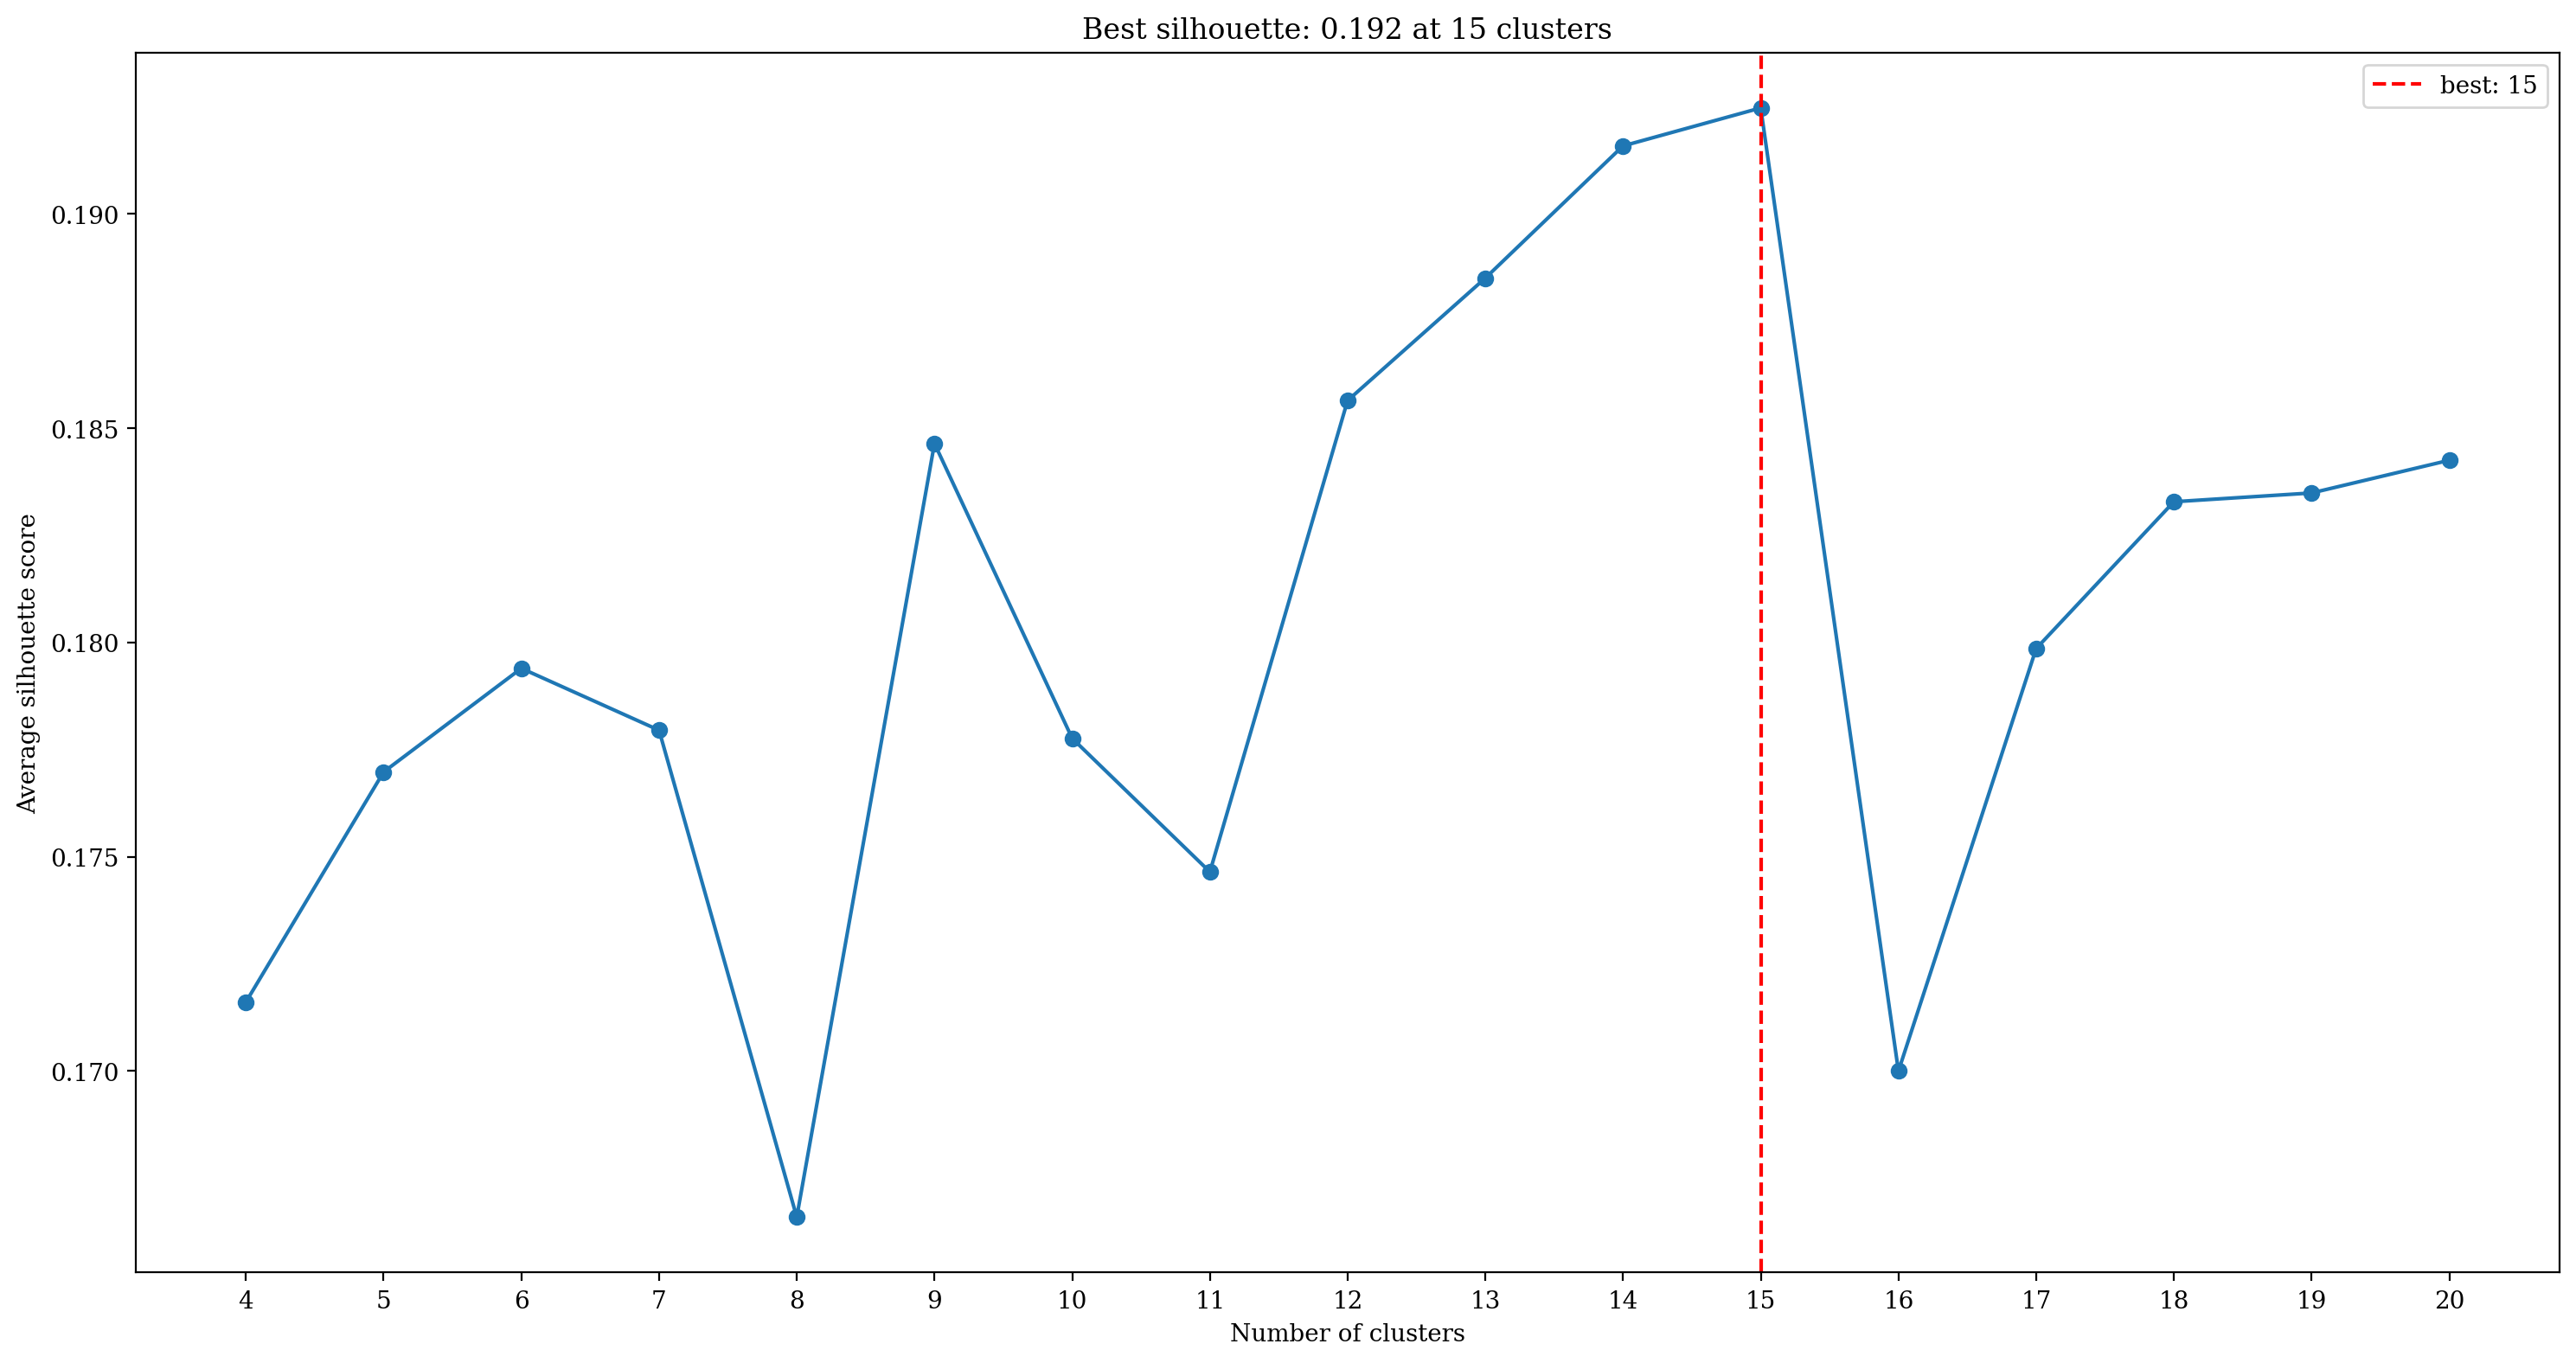

In [223]:
static_data = pd.read_csv(
    "../data/attributes/hydro_atlas_cis_camels.csv", index_col="gage_id", dtype={"gage_id": str}
)
cluster_features = select_uncorrelated_features(static_data, threshold=0.75, min_valid_fraction=0.8)
static_data = static_data.loc[gauge.index, cluster_features]
static_norm = (static_data - static_data.mean()) / static_data.std()
static_norm = static_norm.dropna(axis=1)
raw_features = static_norm.values

plot_silhouette_range(raw_features, min_clusters=4, max_clusters=20, random_state=42);


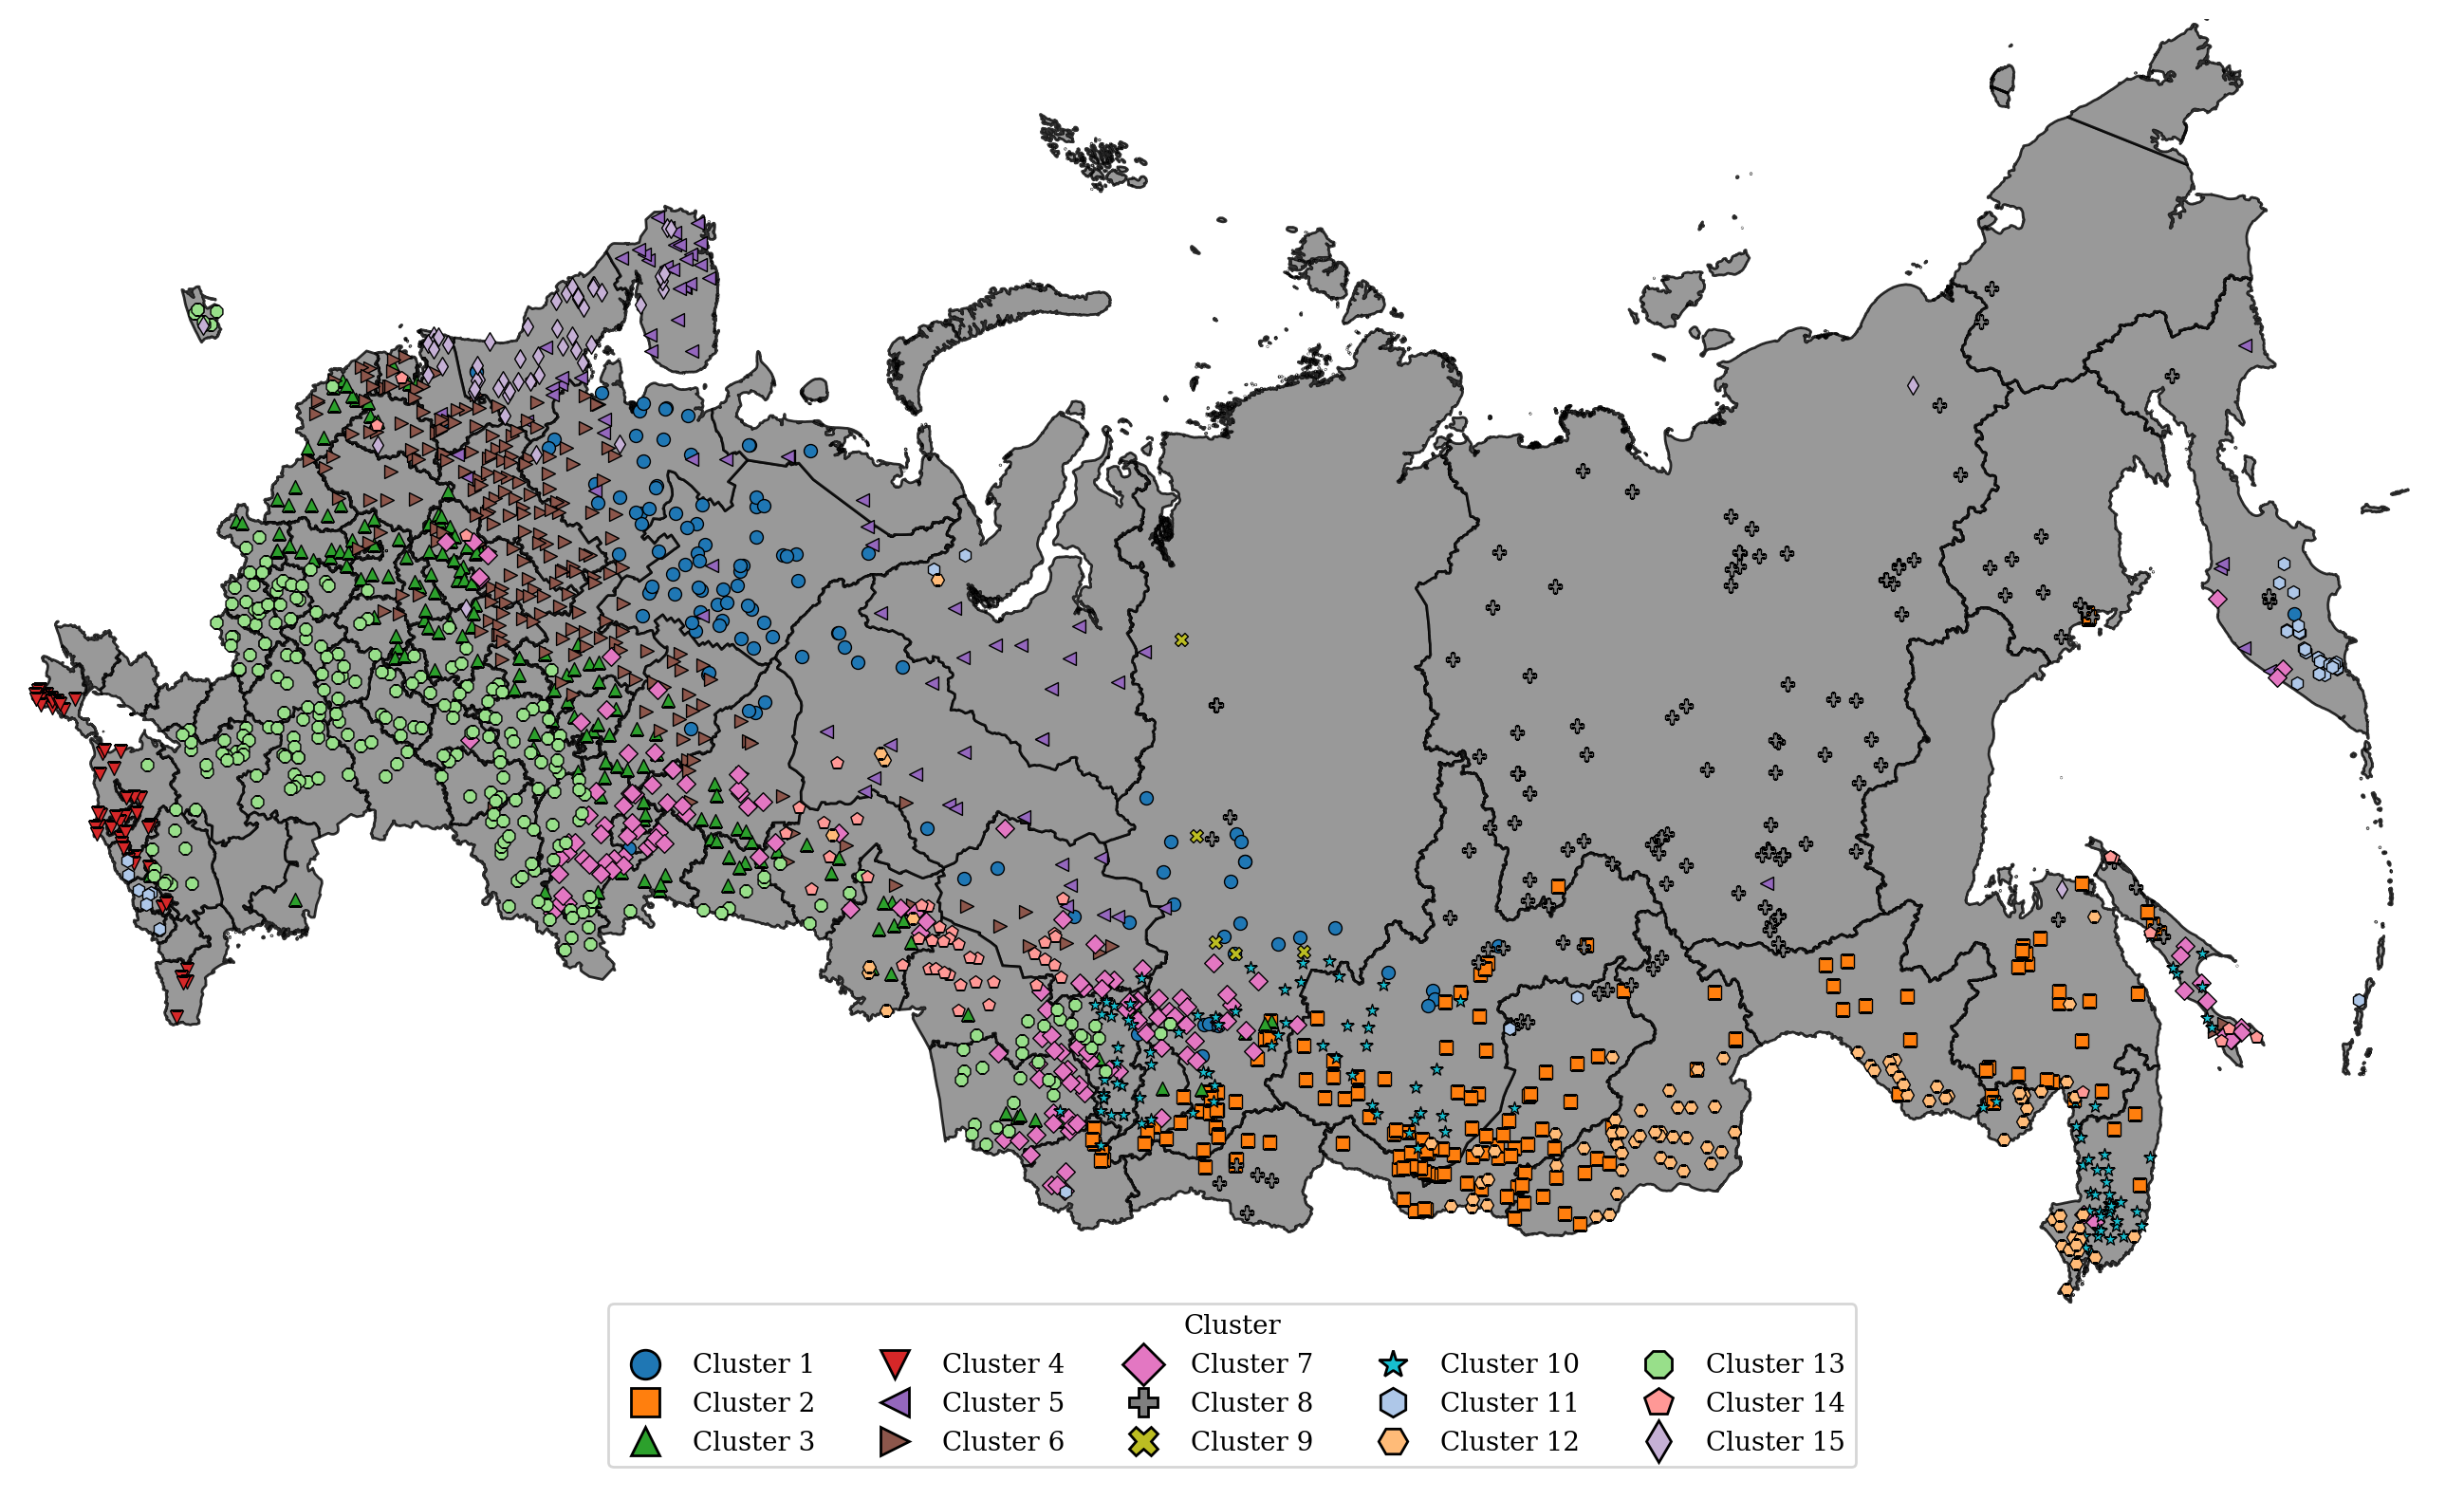

In [250]:
number_of_clusters = 15

cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42, init="k-means++")


y_hat = cluster_alg.fit_predict(raw_features)
static_norm["ResClust"] = [i + 1 for i in y_hat]
gauge["ResClust"] = np.nan
static_data["ResClust"] = np.nan

gauge = gauge.combine_first(static_norm).dropna()
static_data = static_data.combine_first(static_norm).dropna()
gauge["Cluster"] = [f"Cluster {int(i)}" for i in gauge["ResClust"]]

markers = ["o", "s", "^", "v", "<", ">", "D", "P", "X", "*", "h", "H", "8", "p", "d"]
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf",  # cyan
    "#aec7e8",  # light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#ff9896",  # light red
    "#c5b0d5",  # light purple
]

gauges_fig_improved = russia_plots(
    gdf_to_plot=gauge,
    basemap_data=basemap_data,
    distinction_col="Cluster",
    markers_list=markers,
    color_list=colors,
    figsize=(15, 8),
    just_points=True,
    legend_cols=5,
    base_marker_size=25,
    base_linewidth=0.5,
)


### Perform clustering based on hydrological attributes